<a href="https://colab.research.google.com/github/dagousket/ML-course-VIB-2020/blob/master/Histone_marks_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Gene activity prediction from histone mark data

#### Import env

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

random_seed = 666
np.random.seed(random_seed)

#### Import data

In [2]:
train = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/ML-course-VIB-2020/master/data/data_train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/ML-course-VIB-2020/master/data/data_test.csv")

# Save labels in external variable
train_labels = train.pop("Label")
train_index_col = train.pop("GeneId")
test_index_col = test.pop("GeneId")

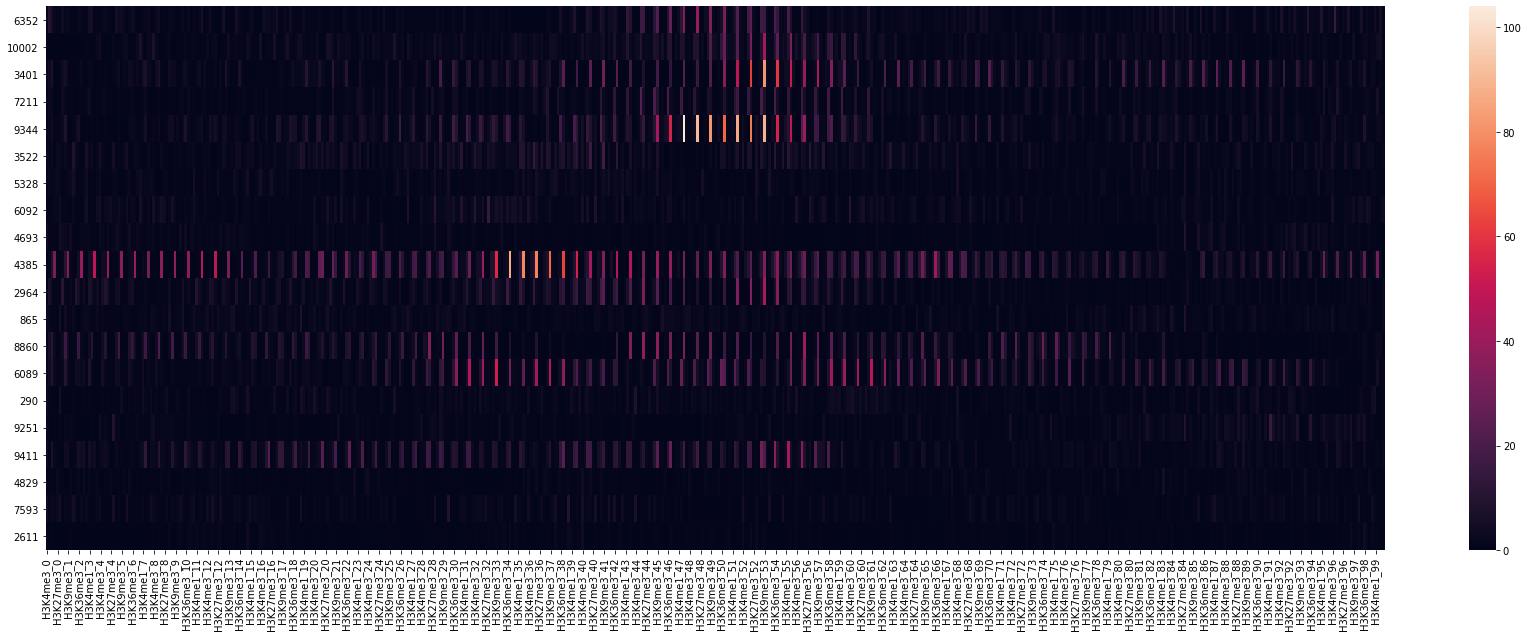

In [3]:
# Look at data
plt.figure(figsize=(30,10))
sns.heatmap(train.sample(20))

#### Generate new features (the fun part)

Feature 1 : max, sum and std of unormalised data for each histone marks

In [4]:
X = train.copy()

marks = list(set([c_name.split("_")[0] for c_name in X.columns]))

def get_global(X, marks):
  tmp_out = {}
  for mark in marks:
    tmp_out[mark + "_sum"] = X.loc[:,[c_name for c_name in X.columns if c_name.startswith(mark)]].sum(axis = 1)
    tmp_out[mark + "_max"] = X.loc[:,[c_name for c_name in X.columns if c_name.startswith(mark)]].max(axis = 1)
    tmp_out[mark + "_std"] = X.loc[:,[c_name for c_name in X.columns if c_name.startswith(mark)]].std(axis = 1)
    tmp_out[mark + "_sumTSS"] = X.loc[:,[mark + "_" + str(bin) for bin in range(40,60)]].sum(axis = 1)
    tmp_out[mark + "_sumUpstream"] = X.loc[:,[mark + "_" + str(bin) for bin in range(0,40)]].sum(axis = 1)
    tmp_out[mark + "_sumDownstream"] = X.loc[:,[mark + "_" + str(bin) for bin in range(60,100)]].sum(axis = 1)
    tmp_out[mark + "_maxTSS"] = X.loc[:,[mark + "_" + str(bin) for bin in range(40,60)]].max(axis = 1)
    tmp_out[mark + "_stdTSS"] = X.loc[:,[mark + "_" + str(bin) for bin in range(40,60)]].std(axis = 1)
    tmp_out[mark + "_stdUpstream"] = X.loc[:,[mark + "_" + str(bin) for bin in range(0,40)]].std(axis = 1)
    tmp_out[mark + "_stdDownstream"] = X.loc[:,[mark + "_" + str(bin) for bin in range(60,100)]].std(axis = 1)
  return pd.DataFrame(tmp_out)

get_global(X.head(), marks)

,H3K36me3_sum,H3K36me3_max,H3K36me3_std,H3K36me3_sumTSS,H3K36me3_sumUpstream,H3K36me3_sumDownstream,H3K36me3_maxTSS,H3K36me3_stdTSS,H3K36me3_stdUpstream,H3K36me3_stdDownstream,H3K4me3_sum,H3K4me3_max,H3K4me3_std,H3K4me3_sumTSS,H3K4me3_sumUpstream,H3K4me3_sumDownstream,H3K4me3_maxTSS,H3K4me3_stdTSS,H3K4me3_stdUpstream,H3K4me3_stdDownstream,H3K9me3_sum,H3K9me3_max,H3K9me3_std,H3K9me3_sumTSS,H3K9me3_sumUpstream,H3K9me3_sumDownstream,H3K9me3_maxTSS,H3K9me3_stdTSS,H3K9me3_stdUpstream,H3K9me3_stdDownstream,H3K4me1_sum,H3K4me1_max,H3K4me1_std,H3K4me1_sumTSS,H3K4me1_sumUpstream,H3K4me1_sumDownstream,H3K4me1_maxTSS,H3K4me1_stdTSS,H3K4me1_stdUpstream,H3K4me1_stdDownstream,H3K27me3_sum,H3K27me3_max,H3K27me3_std,H3K27me3_sumTSS,H3K27me3_sumUpstream,H3K27me3_sumDownstream,H3K27me3_maxTSS,H3K27me3_stdTSS,H3K27me3_stdUpstream,H3K27me3_stdDownstream
0,720,31,7.282191,165,154,401,17,4.447057,3.759092,9.517831,90,3,0.948151,22,17,51,3,1.071153,0.712075,0.905468,2002,84,24.408965,724,59,1219,84,29.319654,1.260596,22.201857,340,17,3.730843,40,45,255,5,1.555973,1.304578,4.130484,166,6,1.265071,29,55,82,4,1.050063,1.371645,1.175607
1,79,4,0.945964,21,31,27,4,1.050063,0.831665,0.997111,175,7,1.472818,35,57,83,5,1.446411,1.217132,1.670061,91,4,0.975405,13,36,42,3,0.933302,0.900142,1.060962,106,4,1.023166,17,41,48,4,0.933302,0.973692,1.114013,76,5,0.954733,13,27,36,5,1.182103,0.828576,0.955416
2,356,19,3.893325,50,216,90,9,2.819108,4.913613,2.157277,321,10,2.253146,31,195,95,4,1.190975,2.232482,1.496791,255,13,2.471555,95,110,50,13,3.006572,2.457328,0.898717,87,3,0.906263,6,46,35,1,0.470162,1.051251,0.790569,97,4,0.979126,9,45,43,2,0.759155,0.991955,0.997111
3,81,4,0.960797,20,30,31,4,1.076055,1.006390,0.861945,240,8,1.657551,50,77,113,5,1.432701,1.347124,1.933344,86,4,0.853040,16,37,33,3,0.894427,0.729858,0.957762,150,6,1.251262,35,57,58,3,0.910465,1.393897,1.259833,122,4,1.142211,21,47,54,3,0.944513,1.152200,1.231010
4,243,12,2.778907,94,36,113,11,3.163942,1.104768,2.881306,81,5,1.011999,24,29,28,5,1.436370,0.986771,0.723241,785,79,16.204735,657,64,64,79,23.175021,1.172331,1.706699,142,6,1.386661,33,55,54,6,1.663066,1.125178,1.494434,271,16,3.065925,26,200,45,4,1.128576,3.637412,1.017476


Feature 2 : gini score

In [8]:
def gini(x):
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

def get_gini(X, marks):
  tmp_out = {}
  res_out = {}
  for mark in marks:
    # Do for unscaled data
    tmp_out[mark] = X.loc[:,[c_name for c_name in X.columns if c_name.startswith(mark)]]
    tmp_out_Up = X.loc[:,[mark + "_" + str(bin) for bin in range(0,40)]]
    tmp_out_Down = X.loc[:,[mark + "_" + str(bin) for bin in range(60,100)]]
    res_out[mark + "_gini"] = tmp_out[mark].apply(lambda y : gini(y.to_numpy()), axis = 1)
    res_out[mark + "_giniUp"] = tmp_out_Up.apply(lambda y : gini(y.to_numpy()), axis = 1)
    res_out[mark + "_giniDown"] = tmp_out_Down.apply(lambda y : gini(y.to_numpy()), axis = 1)
  return pd.DataFrame(res_out)

get_gini(X.head(), marks)

,H3K36me3_gini,H3K36me3_giniUp,H3K36me3_giniDown,H3K4me3_gini,H3K4me3_giniUp,H3K4me3_giniDown,H3K9me3_gini,H3K9me3_giniUp,H3K9me3_giniDown,H3K4me1_gini,H3K4me1_giniUp,H3K4me1_giniDown,H3K27me3_gini,H3K27me3_giniUp,H3K27me3_giniDown
0,0.513056,0.504545,0.498940,0.558444,0.736765,0.382843,0.625834,0.446186,0.406378,0.547353,0.603889,0.343627,0.410000,0.520455,0.305488
1,0.603418,0.541129,0.699074,0.446686,0.447807,0.424398,0.553516,0.515278,0.517857,0.502453,0.510366,0.478125,0.612368,0.619444,0.540278
2,0.540225,0.479630,0.468889,0.388069,0.253718,0.339737,0.475412,0.455455,0.366000,0.553908,0.494565,0.482143,0.537010,0.465000,0.499419
3,0.602840,0.650000,0.578226,0.381000,0.387338,0.377212,0.509070,0.397973,0.581061,0.434667,0.471491,0.468103,0.507213,0.523936,0.497222
4,0.574938,0.600000,0.509513,0.621358,0.664655,0.535714,0.764777,0.403125,0.521094,0.513803,0.445000,0.557407,0.552657,0.390750,0.490556


Feature 3 : proximal vs. distal enrichment + upstream vs. downstream enrichment

In [9]:
from scipy import stats

def get_binom(X, marks):
  tmp_out = {}
  res_out = {}
  for mark in marks:
    tmp_out[mark] = X.loc[:,[c_name for c_name in X.columns if c_name.startswith(mark)]]
    res_out[mark + "_TSSenrich"] = tmp_out[mark].apply(lambda y : stats.binom_test(sum(y[range(40,60)]), n = sum(y)), axis = 1)
    res_out[mark + "_Upstreamenrich"] = tmp_out[mark].apply(lambda y : stats.binom_test(sum(y[range(0,40)]), n = sum(y)), axis = 1)
    res_out[mark + "_Downstreamenrich"] = tmp_out[mark].apply(lambda y : stats.binom_test(sum(y[range(60,100)]), n = sum(y)), axis = 1)
  return pd.DataFrame(res_out)

get_binom(X.head(), marks)

,H3K36me3_TSSenrich,H3K36me3_Upstreamenrich,H3K36me3_Downstreamenrich,H3K4me3_TSSenrich,H3K4me3_Upstreamenrich,H3K4me3_Downstreamenrich,H3K9me3_TSSenrich,H3K9me3_Upstreamenrich,H3K9me3_Downstreamenrich,H3K4me1_TSSenrich,H3K4me1_Upstreamenrich,H3K4me1_Downstreamenrich,H3K27me3_TSSenrich,H3K27me3_Upstreamenrich,H3K27me3_Downstreamenrich
0,3.733584e-50,3.654592e-56,2.514933e-03,1.249258e-06,1.948238e-09,2.461064e-01,1.593505e-35,4.940656e-324,1.662689e-22,2.102173e-50,3.444953e-46,7.196681e-21,5.483568e-18,1.652693e-05,9.381653e-01
1,3.761513e-05,7.116341e-02,6.553298e-03,4.473770e-16,4.655217e-06,5.454727e-01,1.847759e-12,5.857353e-02,5.296021e-01,5.912079e-13,2.502135e-02,3.821258e-01,5.044924e-09,1.544026e-02,7.310089e-01
2,5.391031e-46,6.635545e-05,2.592788e-21,7.172829e-54,1.396336e-04,1.846451e-13,5.624687e-05,3.303690e-02,1.844212e-23,7.034486e-18,6.682850e-01,8.568897e-02,2.003791e-17,5.426102e-01,3.099335e-01
3,5.656215e-06,2.565436e-02,4.482852e-02,2.112110e-20,2.941913e-08,4.014365e-01,3.206380e-09,2.353799e-01,3.985363e-02,3.768667e-11,4.113299e-03,6.851639e-03,9.677506e-14,1.417049e-02,2.390888e-01
4,5.062892e-04,2.284488e-30,3.046949e-01,3.173169e-04,1.399947e-02,7.275502e-03,1.910826e-86,1.133129e-141,1.133129e-141,1.094288e-10,9.043247e-03,5.430090e-03,7.651716e-46,2.181818e-15,3.480774e-30


Feature 4 : Distance TSS-Max and Polyfit at Max position on library sized data

In [10]:
def find_slope_from_bins(mybins):
  maxbin = np.argmax(mybins)
  upstream_bins = mybins[range(max(0,maxbin-15),maxbin)]
  downstream_bins = mybins[range(maxbin,min(len(mybins),maxbin+15))]
  full_bins = mybins[range(max(0,maxbin-15),min(len(mybins),maxbin+15))]
  if len(upstream_bins) > 5 :
    upSlope = np.polyfit(range(0,len(upstream_bins)),upstream_bins,1)[0]
  else :
      upSlope = 0
  if len(downstream_bins) > 5 :
    downSlope = np.polyfit(range(0,len(downstream_bins)),downstream_bins,1)[0]
  else :
    downSlope = 0
  if len(full_bins) > 10 :
    fullSlope = np.polyfit(range(0,len(full_bins)),full_bins,2)
    fullSlope2 = fullSlope[0]
    fullSlope1 = fullSlope[1]
  else :
    fullSlope2 = 0
    fullSlope1 = 0
  return [maxbin, upSlope, downSlope, fullSlope2, fullSlope1]

def get_polyfit(X, marks):
  tmp_out = {}
  res_out = {}
  for mark in marks:
    tmp_out[mark] = X.loc[:,[c_name for c_name in X.columns if c_name.startswith(mark)]]
    tmp_out[mark] = tmp_out[mark].div(tmp_out[mark].sum(axis=1), axis=0)
    res_out[mark + "_Polyfit"] = tmp_out[mark].apply(lambda y : find_slope_from_bins(y.to_numpy()), axis = 1)
    res_out[mark + "_maxBin"] = res_out[mark + "_Polyfit"].apply(lambda y : y[0])
    res_out[mark + "_upSlope"] = res_out[mark + "_Polyfit"].apply(lambda y : y[1])
    res_out[mark + "_downSlope"] = res_out[mark + "_Polyfit"].apply(lambda y : y[2])
    res_out[mark + "_fullSlope1"] = res_out[mark + "_Polyfit"].apply(lambda y : y[3])
    res_out[mark + "_fullSlope2"] = res_out[mark + "_Polyfit"].apply(lambda y : y[4])
  res_out = pd.DataFrame(res_out).drop(labels = [mark + "_Polyfit" for mark in marks], axis = 1)
  return pd.DataFrame(res_out)

get_polyfit(X.head(), marks) 

,H3K36me3_maxBin,H3K36me3_upSlope,H3K36me3_downSlope,H3K36me3_fullSlope1,H3K36me3_fullSlope2,H3K4me3_maxBin,H3K4me3_upSlope,H3K4me3_downSlope,H3K4me3_fullSlope1,H3K4me3_fullSlope2,H3K9me3_maxBin,H3K9me3_upSlope,H3K9me3_downSlope,H3K9me3_fullSlope1,H3K9me3_fullSlope2,H3K4me1_maxBin,H3K4me1_upSlope,H3K4me1_downSlope,H3K4me1_fullSlope1,H3K4me1_fullSlope2,H3K27me3_maxBin,H3K27me3_upSlope,H3K27me3_downSlope,H3K27me3_fullSlope1,H3K27me3_fullSlope2
0,94,0.002674,-0.005952,-0.000218,0.005800,33,2.777778e-04,0.000040,-0.000008,0.000766,52,0.002101,-0.000319,-0.000062,0.003092,96,0.002416,0.000000,-0.000169,0.004685,3,0.000000,-0.000452,0.000163,-0.003315
1,58,0.000859,-0.001763,-0.000066,0.001899,78,4.007862e-19,-0.001245,-0.000027,0.000464,70,0.000863,-0.000628,-0.000040,0.001339,40,0.000708,-0.000741,-0.000043,0.000923,51,-0.001598,-0.000235,0.000063,-0.001623
2,33,0.001605,-0.003401,-0.000152,0.004328,25,2.670227e-04,-0.000590,-0.000025,0.000790,41,0.001835,-0.000980,-0.000069,0.002127,0,0.000000,-0.001601,-0.000070,-0.000626,20,0.000994,-0.000736,-0.000049,0.001629
3,0,0.000000,-0.001852,0.000038,-0.002383,96,-3.869048e-04,0.000000,0.000109,-0.001866,98,0.001246,0.000000,-0.000082,0.002602,2,0.000000,-0.000619,0.000111,-0.002282,17,-0.000615,-0.001317,-0.000022,0.000474
4,63,0.002660,-0.001911,-0.000135,0.003535,48,-6.613757e-04,-0.000617,0.000021,-0.000726,52,0.005610,-0.006688,-0.000354,0.010127,50,-0.000453,-0.001207,-0.000021,0.000252,28,0.001608,-0.001885,-0.000091,0.002153


#### Feature 5 : Correlation between marks

In [12]:
!pip install pingouin

     |████████████████████████████████| 225kB 5.9MB/s 
  Created wheel for pingouin: filename=pingouin-0.3.8-cp36-none-any.whl size=221687 sha256=3bf1a065170b01c748f57bf6c4f4268ac1d3ffad726e568f3c6874af626f4ad1
  Stored in directory: /root/.cache/pip/wheels/d6/9e/53/f885f73f29cf7c8cac3d8f4b1532bbfef2f5eb543946ac9055
  Created wheel for outdated: filename=outdated-0.2.0-cp36-none-any.whl size=4962 sha256=6fd37bd01f13994d7998ce5036f832b33e7d2355eaf8167baa60f780eafb4609
  Stored in directory: /root/.cache/pip/wheels/fd/7c/ef/814f514d31197310872b5abf353feb8fef9d67ee658e1e7e39
  Created wheel for littleutils: filename=littleutils-0.2.2-cp36-none-any.whl size=7050 sha256=455840ac92b0413ec3078059eee49724133e748278c38798d9f49232b3f1bf98
  Stored in directory: /root/.cache/pip/wheels/53/16/9f/ac67d15c40243754fd73f620e1b9b6dedc20492ecc19a2bae1
Successfully built pingouin outdated littleutils


In [13]:
import pingouin as pg

def find_cor_from_bins(mybins, marks) :
  res_out = pd.DataFrame()
  df = pd.DataFrame()
  for mark in marks :
      df.reset_index()
      df[mark] = mybins[[mark + "_" + str(bin) for bin in range(0,10)]].to_numpy()
  try :
    dfcor = pg.pairwise_corr(df, method='pearson', padjust='none').loc[:, ['X','Y','r2','r']]
    column_name = dfcor["X"] + "::" + dfcor["Y"] + "pearson"
    dfcor = dfcor.loc[:,['r2','r']].T
    dfcor.columns = column_name
    res_out = pd.concat([res_out, dfcor], axis = 1)
    res_out_z = pd.DataFrame(res_out.iloc[1,:])
    res_out_z.index = [cn + "_R" for cn in res_out_z.index]
    res_out_z.columns = ['cor']
    res_out_r = pd.DataFrame(res_out.iloc[0,:])
    res_out_r.index = [cn + "_R2" for cn in res_out_r.index]
    res_out_r.columns = ['cor']
    res_out = pd.concat([res_out_r, res_out_z], axis = 0)
  except :
    res_out = pd.DataFrame()
    res_out['cor'] = [0] * 20
  res_out = pd.Series( res_out.loc[:,'cor'] )
  return res_out

def get_corpcor(X, marks):
  res_out = X.apply(lambda y : find_cor_from_bins(y, marks), axis = 1)
  return (res_out)

get_corpcor(X.head(), marks) 

,H3K36me3::H3K4me3pearson_R2,H3K36me3::H3K9me3pearson_R2,H3K36me3::H3K4me1pearson_R2,H3K36me3::H3K27me3pearson_R2,H3K4me3::H3K9me3pearson_R2,H3K4me3::H3K4me1pearson_R2,H3K4me3::H3K27me3pearson_R2,H3K9me3::H3K4me1pearson_R2,H3K9me3::H3K27me3pearson_R2,H3K4me1::H3K27me3pearson_R2,H3K36me3::H3K4me3pearson_R,H3K36me3::H3K9me3pearson_R,H3K36me3::H3K4me1pearson_R,H3K36me3::H3K27me3pearson_R,H3K4me3::H3K9me3pearson_R,H3K4me3::H3K4me1pearson_R,H3K4me3::H3K27me3pearson_R,H3K9me3::H3K4me1pearson_R,H3K9me3::H3K27me3pearson_R,H3K4me1::H3K27me3pearson_R
0,1.097231e-01,2.101190e-01,0.597682,0.220078,0.235458,0.090909,0.045297,0.034483,0.000650,0.280277,3.312447e-01,4.583874e-01,0.773099,0.469125,0.485240,0.301511,-0.212832,0.185695,-0.025488,0.529412
1,1.851852e-01,7.703720e-34,0.197531,0.457995,0.078431,0.000000,0.365854,0.032680,0.064562,0.024390,4.303315e-01,2.775558e-17,-0.444444,0.676753,0.280056,0.000000,0.604858,0.180775,-0.254091,-0.156174
2,5.330162e-03,1.304348e-01,0.116632,0.043737,0.000760,0.299645,0.062131,0.047619,0.060020,0.074074,-7.300796e-02,3.611576e-01,0.341515,0.209134,0.027566,0.547399,0.249260,0.218218,0.244989,0.272166
3,5.067050e-01,4.693487e-02,0.001582,0.272222,0.042806,0.039759,0.062069,0.035464,0.172414,0.000712,7.118321e-01,2.166446e-01,-0.039770,0.521749,0.206897,0.199398,0.249136,0.188320,0.415227,-0.026679
4,1.733337e-33,3.500432e-01,0.117057,0.000445,0.269663,0.083851,0.582852,0.196036,0.008118,0.195491,4.163336e-17,-5.916445e-01,0.342136,0.021087,-0.519291,0.289570,0.763447,-0.442760,-0.090103,0.442143


#### Create final train + test datasets

In [14]:
train_feat = pd.concat([get_global(X, marks), get_polyfit(X, marks), get_gini(X, marks), get_binom(X, marks), get_corpcor(X, marks)], axis = 1)
test_feat = pd.concat([get_global(test, marks), get_polyfit(test, marks), get_gini(test, marks), get_binom(test, marks), get_corpcor(test, marks)], axis = 1)

train_feat = train_feat.fillna(0)
train_feat.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/usr/local/lib/python3.6/dist-packages/pingouin/effsize.py:135: RuntimeWarning: divide by zero encountered in arctanh
  z = np.arctanh(stat)  # R-to-z transform
/usr/local/lib/python3.6/dist-packages/pingouin/power.py:899: RuntimeWarning: divide by zero encountered in arctanh
  zr = np.arctanh(r) + r / (2 * (n - 1))
/usr/local/lib/python3.6/dist-packages/pingouin/pairwise.py:1274: RuntimeWarning: divide by zero encountered in arctanh
  stats['z'] = np.arctanh(stats['r'].to_numpy())
/usr/local/lib/python3.6/dist-packages/pingouin/effsize.py:135: RuntimeWarning: divide by zero encountered in arctanh
  z = np.arctanh(stat)  # R-to-z transform
/usr/local/lib/python3.6/dist-packages/pingouin/power.py:899: RuntimeWarning: divide by zero encountered in arctanh
  zr = np.arctanh(r) + r / (2 * (n - 1))
/usr/local/lib/python3.6/dist-packages/pingouin/pairwise.py:1274:

,H3K36me3_sum,H3K36me3_max,H3K36me3_std,H3K36me3_sumTSS,H3K36me3_sumUpstream,H3K36me3_sumDownstream,H3K36me3_maxTSS,H3K36me3_stdTSS,H3K36me3_stdUpstream,H3K36me3_stdDownstream,H3K4me3_sum,H3K4me3_max,H3K4me3_std,H3K4me3_sumTSS,H3K4me3_sumUpstream,H3K4me3_sumDownstream,H3K4me3_maxTSS,H3K4me3_stdTSS,H3K4me3_stdUpstream,H3K4me3_stdDownstream,H3K9me3_sum,H3K9me3_max,H3K9me3_std,H3K9me3_sumTSS,H3K9me3_sumUpstream,H3K9me3_sumDownstream,H3K9me3_maxTSS,H3K9me3_stdTSS,H3K9me3_stdUpstream,H3K9me3_stdDownstream,H3K4me1_sum,H3K4me1_max,H3K4me1_std,H3K4me1_sumTSS,H3K4me1_sumUpstream,H3K4me1_sumDownstream,H3K4me1_maxTSS,H3K4me1_stdTSS,H3K4me1_stdUpstream,H3K4me1_stdDownstream,...,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,H3K36me3::H3K27me3pearson_R,H3K36me3::H3K27me3pearson_R2,H3K36me3::H3K4me1pearson_R,H3K36me3::H3K4me1pearson_R2,H3K36me3::H3K4me3pearson_R,H3K36me3::H3K4me3pearson_R2,H3K36me3::H3K9me3pearson_R,H3K36me3::H3K9me3pearson_R2,H3K4me1::H3K27me3pearson_R,H3K4me1::H3K27me3pearson_R2,H3K4me3::H3K27me3pearson_R,H3K4me3::H3K27me3pearson_R2,H3K4me3::H3K4me1pearson_R,H3K4me3::H3K4me1pearson_R2,H3K4me3::H3K9me3pearson_R,H3K4me3::H3K9me3pearson_R2,H3K9me3::H3K27me3pearson_R,H3K9me3::H3K27me3pearson_R2,H3K9me3::H3K4me1pearson_R,H3K9me3::H3K4me1pearson_R2
0,720,31,7.282191,165,154,401,17,4.447057,3.759092,9.517831,90,3,0.948151,22,17,51,3,1.071153,0.712075,0.905468,2002,84,24.408965,724,59,1219,84,29.319654,1.260596,22.201857,340,17,3.730843,40,45,255,5,1.555973,1.304578,4.130484,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.469125,0.220078,0.773099,0.597682,3.312447e-01,1.097231e-01,4.583874e-01,2.101190e-01,0.529412,0.280277,-0.212832,0.045297,0.301511,0.090909,0.485240,0.235458,-0.025488,0.000650,0.185695,0.034483
1,79,4,0.945964,21,31,27,4,1.050063,0.831665,0.997111,175,7,1.472818,35,57,83,5,1.446411,1.217132,1.670061,91,4,0.975405,13,36,42,3,0.933302,0.900142,1.060962,106,4,1.023166,17,41,48,4,0.933302,0.973692,1.114013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.676753,0.457995,-0.444444,0.197531,4.303315e-01,1.851852e-01,2.775558e-17,7.703720e-34,-0.156174,0.024390,0.604858,0.365854,0.000000,0.000000,0.280056,0.078431,-0.254091,0.064562,0.180775,0.032680
2,356,19,3.893325,50,216,90,9,2.819108,4.913613,2.157277,321,10,2.253146,31,195,95,4,1.190975,2.232482,1.496791,255,13,2.471555,95,110,50,13,3.006572,2.457328,0.898717,87,3,0.906263,6,46,35,1,0.470162,1.051251,0.790569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.209134,0.043737,0.341515,0.116632,-7.300796e-02,5.330162e-03,3.611576e-01,1.304348e-01,0.272166,0.074074,0.249260,0.062131,0.547399,0.299645,0.027566,0.000760,0.244989,0.060020,0.218218,0.047619
3,81,4,0.960797,20,30,31,4,1.076055,1.006390,0.861945,240,8,1.657551,50,77,113,5,1.432701,1.347124,1.933344,86,4,0.853040,16,37,33,3,0.894427,0.729858,0.957762,150,6,1.251262,35,57,58,3,0.910465,1.393897,1.259833,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.521749,0.272222,-0.039770,0.001582,7.118321e-01,5.067050e-01,2.166446e-01,4.693487e-02,-0.026679,0.000712,0.249136,0.062069,0.199398,0.039759,0.206897,0.042806,0.415227,0.172414,0.188320,0.035464
4,243,12,2.778907,94,36,113,11,3.163942,1.104768,2.881306,81,5,1.011999,24,29,28,5,1.436370,0.986771,0.723241,785,79,16.204735,657,64,64,79,23.175021,1.172331,1.706699,142,6,1.386661,33,55,54,6,1.663066,1.125178,1.494434,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021087,0.000445,0.342136,0.117057,4.163336e-17,1.733337e-33,-5.916445e-01,3.500432e-01,0.442143,0.195491,0.763447,0.582852,0.289570,0.083851,-0.519291,0.269663,-0.090103,0.008118,-0.442760,0.196036


In [15]:
test_feat = test_feat.fillna(0)
test_feat.head()

,H3K36me3_sum,H3K36me3_max,H3K36me3_std,H3K36me3_sumTSS,H3K36me3_sumUpstream,H3K36me3_sumDownstream,H3K36me3_maxTSS,H3K36me3_stdTSS,H3K36me3_stdUpstream,H3K36me3_stdDownstream,H3K4me3_sum,H3K4me3_max,H3K4me3_std,H3K4me3_sumTSS,H3K4me3_sumUpstream,H3K4me3_sumDownstream,H3K4me3_maxTSS,H3K4me3_stdTSS,H3K4me3_stdUpstream,H3K4me3_stdDownstream,H3K9me3_sum,H3K9me3_max,H3K9me3_std,H3K9me3_sumTSS,H3K9me3_sumUpstream,H3K9me3_sumDownstream,H3K9me3_maxTSS,H3K9me3_stdTSS,H3K9me3_stdUpstream,H3K9me3_stdDownstream,H3K4me1_sum,H3K4me1_max,H3K4me1_std,H3K4me1_sumTSS,H3K4me1_sumUpstream,H3K4me1_sumDownstream,H3K4me1_maxTSS,H3K4me1_stdTSS,H3K4me1_stdUpstream,H3K4me1_stdDownstream,...,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,H3K36me3::H3K27me3pearson_R,H3K36me3::H3K27me3pearson_R2,H3K36me3::H3K4me1pearson_R,H3K36me3::H3K4me1pearson_R2,H3K36me3::H3K4me3pearson_R,H3K36me3::H3K4me3pearson_R2,H3K36me3::H3K9me3pearson_R,H3K36me3::H3K9me3pearson_R2,H3K4me1::H3K27me3pearson_R,H3K4me1::H3K27me3pearson_R2,H3K4me3::H3K27me3pearson_R,H3K4me3::H3K27me3pearson_R2,H3K4me3::H3K4me1pearson_R,H3K4me3::H3K4me1pearson_R2,H3K4me3::H3K9me3pearson_R,H3K4me3::H3K9me3pearson_R2,H3K9me3::H3K27me3pearson_R,H3K9me3::H3K27me3pearson_R2,H3K9me3::H3K4me1pearson_R,H3K9me3::H3K4me1pearson_R2
0,661,29,6.725340,179,436,46,29,7.394699,5.803624,1.494434,87,4,0.939106,21,32,34,4,1.050063,0.882886,0.948683,1014,103,20.028777,805,133,76,103,29.415132,3.452145,1.629850,209,8,1.688314,64,102,43,8,2.015728,1.616422,0.858965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.102062,0.010417,0.358758,0.128708,0.400287,0.160229,-0.446844,0.199670,0.097642,0.009534,-0.053000,0.002809,-0.082800,0.006856,-3.164212e-02,1.001224e-03,0.348263,0.121287,-0.297948,0.088773
1,205,10,2.540083,112,42,51,10,3.267060,1.060962,1.395735,166,7,1.444040,40,55,71,5,1.555973,1.274755,1.527315,141,5,1.247988,37,36,68,5,1.694418,1.032796,1.017790,123,7,1.229724,25,43,55,3,0.786398,1.047280,1.547330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.254298,0.064668,0.287348,0.082569,0.153594,0.023591,0.557124,0.310387,0.684762,0.468899,-0.292174,0.085366,0.020559,0.000423,8.757958e-02,7.670182e-03,0.614124,0.377148,0.573462,0.328859
2,212,14,2.825855,127,51,34,14,3.543341,1.358497,0.863802,354,14,3.189060,133,121,100,14,3.248886,3.141839,2.112235,195,12,2.583456,119,42,34,12,3.017057,1.131144,0.975337,110,4,1.020002,26,40,44,3,1.174286,0.905822,1.057331,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.094124,0.008859,0.333914,0.111498,-0.504827,0.254850,-0.315244,0.099379,0.041251,0.001702,0.127176,0.016174,-0.329700,0.108702,-9.829464e-02,9.661836e-03,0.480317,0.230704,0.092106,0.008484
3,494,33,6.386254,98,311,85,15,4.290749,8.318923,2.997328,83,6,1.064154,15,30,38,3,0.850696,0.839719,1.338771,1235,89,21.315985,920,229,86,89,25.583712,9.943398,1.805263,230,8,1.660595,45,105,80,5,1.292692,2.021519,1.377474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.242536,0.058824,0.405340,0.164300,-0.232425,0.054022,0.485071,0.235294,-0.309492,0.095785,0.745356,0.555556,-0.355909,0.126671,6.938894e-18,4.814825e-35,0.111111,0.012346,0.526137,0.276820
4,476,16,3.861543,154,109,213,15,3.062507,2.385721,4.310913,142,8,1.646423,19,22,101,3,0.887041,0.875595,1.894493,861,82,16.641736,659,61,141,82,24.949370,1.320208,4.025480,287,16,2.714179,43,188,56,3,1.039990,3.212156,1.392286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.296296,0.087791,0.322668,0.104114,0.014226,0.000202,-0.313131,0.098051,-0.200577,0.040231,-0.554826,0.307832,0.472312,0.223079,4.539489e-01,2.060696e-01,0.242424,0.058770,0.330596,0.109293


In [29]:
for mark in marks:
  train_feat[mark + "_ratio"] = train_feat[mark + "_sumUpstream"] / train_feat[mark + "_sumDownstream"]
  test_feat[mark + "_ratio"] = train_feat[mark + "_sumUpstream"] / train_feat[mark + "_sumDownstream"]

In [16]:
# Verfify you have the same number of rows
print(train.shape)
print(train_feat.shape)
print(test.shape)
print(test_feat.shape)

(10436, 500)
(10436, 145)
(5049, 500)
(5049, 145)


##### Random Forest model

In [17]:
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from scipy.stats import randint
import xgboost as xgb

In [18]:
# Initialize a variable that will hold our model
rf_handle = RandomForestClassifier()

# Define parameter distributions
param_dist = {"n_estimators"      : [50],
              "max_depth"         : randint(1,50),
              "min_samples_split" : randint(3, 50),
              "min_samples_leaf"  : randint(3, 50),
              "bootstrap"         : [True, False]}

# Define the number of parameter sets to search for
n_iter_search = 30

# Initialize the randomized search cv
random_search = RandomizedSearchCV(rf_handle, param_distributions=param_dist,
                                   n_iter=n_iter_search,verbose=10,scoring="neg_log_loss", refit = True,
                                   n_jobs=8,cv=StratifiedKFold(n_splits=5, shuffle=True,random_state=42))

# Start the search for the best parameters, cv evaluation and final fitting on the best parameters
random_search = random_search.fit(train_feat, train_labels)

# Point to the best model with this variable
rf_model = random_search.best_estimator_


Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   16.9s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:   40.8s
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:   47.9s


KeyboardInterrupt: ignored

In [ ]:
# Make predictions for the test set
predictions = rf_model.predict_proba(test_feat)

predictions_df = pd.DataFrame({"GeneId":test_index_col,"Label":predictions[:,1]})
predictions_df.to_csv('submission_rf.csv', index=False)

#### XGBoost model

In [34]:
from scipy.stats import uniform, randint

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric = "logloss")

params = {
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 10), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.8, 0.95)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params,
                            random_state=42, n_iter=70, cv=StratifiedKFold(n_splits=10, shuffle=True,random_state=42),
                            verbose=1, n_jobs=10, return_train_score=True,
                            scoring="neg_log_loss", refit = True)

search.fit(train_feat, train_labels)


Fitting 10 folds for each of 70 candidates, totalling 700 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:  3.0min
[Parallel(n_jobs=10)]: Done 200 tasks      | elapsed: 14.1min
[Parallel(n_jobs=10)]: Done 450 tasks      | elapsed: 23.6min
[Parallel(n_jobs=10)]: Done 700 out of 700 | elapsed: 36.9min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric='logloss', gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthre...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb023d14c88>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fb023d1

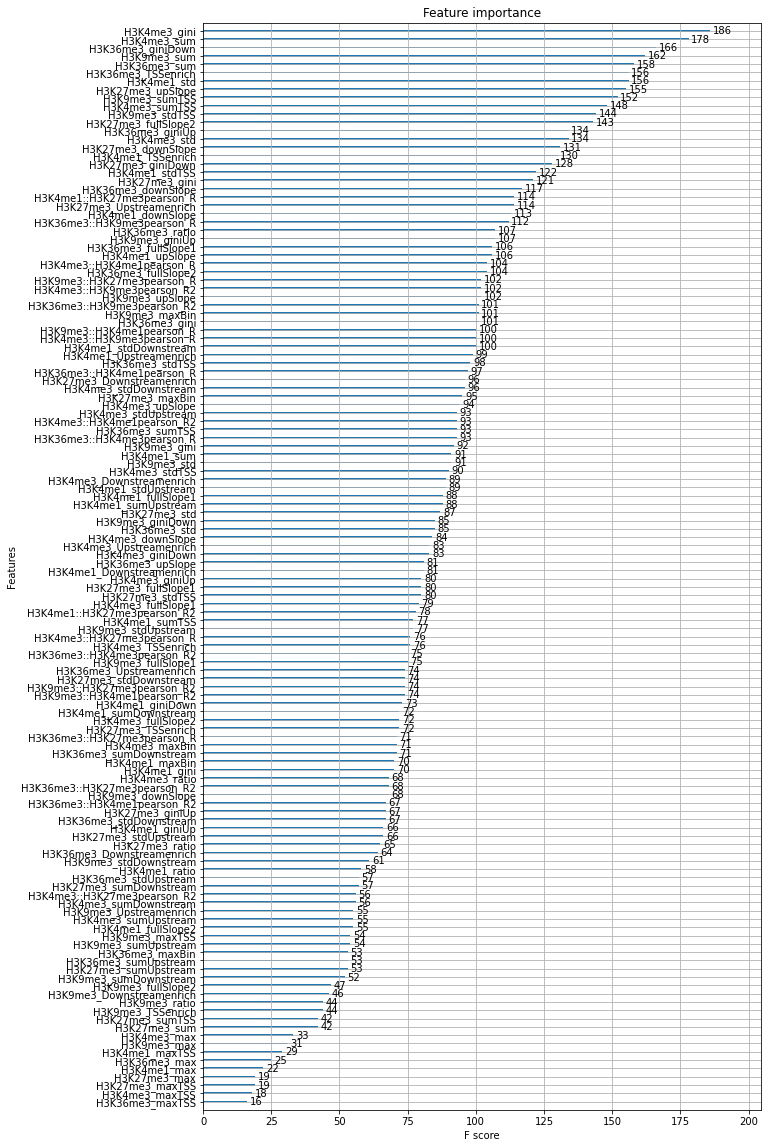

In [35]:
# Point to the best model with this variable
xgb_model = search.best_estimator_

ax = xgb.plot_importance(xgb_model)
fig = ax.figure
fig.set_size_inches(10, 20)

In [36]:
# Make predictions for the test set
predictions = xgb_model.predict_proba(test_feat)

predictions_df = pd.DataFrame({"GeneId":test_index_col,"Label":predictions[:,1]})
predictions_df.to_csv('submission_xgb8.csv', index=False)